<a href="https://colab.research.google.com/github/julcoh/fruitPOP-tools/blob/main/fruitPOP_Sorting_Hat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# =============================================================================
# 0.  Install the libraries we need
# -----------------------------------------------------------------------------
# • ortools          – Google’s optimisation toolkit (CP-SAT solver)
# • gspread          – Python API for Google Sheets
# • gspread_dataframe– Helper: move whole DataFrames in/out of Sheets
# • oauth2client     – Handles the OAuth dance inside Colab
# =============================================================================
!pip install -q ortools gspread gspread_dataframe oauth2client

# =============================================================================
# 1.  Authenticate this Colab session with your Google account
# -----------------------------------------------------------------------------
# Colab’s auth helper pops up a consent screen; once you allow it,
# the notebook inherits a short-lived credential that works with
# both Google Drive and Google Sheets.
# =============================================================================
from google.colab import auth
auth.authenticate_user()     # <-- you’ll get a clickable login link

# Build a gspread “client” that can read / write spreadsheets.
import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.auth import default           # picks up the Colab creds

creds, _ = default()                      # creds = OAuth token object
gc = gspread.authorize(creds)             # gspread client authorised

import pandas as pd



In [ ]:
### DEFINE SOLVER FUNCTION ###

from ortools.sat.python import cp_model

def run_shift_solver(volunteers, shift_ids, shifts_df, prefs_input, min_points, max_over, seed=69):
    """
    Solve volunteer shift assignment using a 2-step CP-SAT model.

    Args:
        volunteers: List of volunteer names
        shift_ids: List of shift IDs
        shifts_df: DataFrame with ShiftID, Capacity, Points
        prefs_input: either a DataFrame (real case) or dict-of-dict (Monte Carlo)
                     where prefs_input[v][s] = rank
        min_points: minimum point total per volunteer
        max_over: max allowed points over the minimum
        seed: int for randomization tie-breaking

    Returns:
        (status_name: str, assignments: dict[volunteer] = shift)
    """
    rand = random.Random(seed)
    points_d = dict(zip(shifts_df['ShiftID'], shifts_df['Points']))

    # Normalize preferences lookup
    def get_rank(v, s):
        if isinstance(prefs_input, pd.DataFrame):
            val = prefs_input.at[v, s] if s in prefs_input.columns else float('inf')
            return int(val) if not pd.isna(val) else float('inf')
        return prefs_input.get(v, {}).get(s, float('inf'))

    # STEP A: Find smallest rank_cut so each volunteer has at least 1 eligible shift
    def cutoff_feasible(r_cut):
        m = cp_model.CpModel()
        x = {(v, s): m.NewBoolVar(f'x_{v}_{s}')
             for v in volunteers for s in shift_ids if get_rank(v, s) <= r_cut}

        for s in shift_ids:
            cap = int(shifts_df.loc[shifts_df['ShiftID'] == s, 'Capacity'].values[0])
            m.Add(sum(x.get((v, s), 0) for v in volunteers) <= cap)

        for v in volunteers:
            elig = [x[(v, s)] for s in shift_ids if (v, s) in x]
            if not elig:
                return False
            m.Add(sum(elig) >= 1)

        solver = cp_model.CpSolver()
        solver.parameters.max_time_in_seconds = 5
        return solver.Solve(m) in (cp_model.FEASIBLE, cp_model.OPTIMAL)

    max_rank = 100  # conservative upper bound
    best_cut = None
    for r in range(1, max_rank + 1):
        if cutoff_feasible(r):
            best_cut = r
            break
    if best_cut is None:
        raise ValueError("❌ No rank_cut found that lets everyone get a shift.")

    # STEP B: Solve full assignment problem
    m2 = cp_model.CpModel()
    x = {(v, s): m2.NewBoolVar(f'x_{v}_{s}') for v in volunteers for s in shift_ids}

    for s in shift_ids:
        cap = int(shifts_df.loc[shifts_df['ShiftID'] == s, 'Capacity'].values[0])
        m2.Add(sum(x[v, s] for v in volunteers) <= cap)

    for v in volunteers:
        total_pts = sum(x[v, s] * points_d[s] for s in shift_ids)
        m2.Add(total_pts >= min_points)
        m2.Add(total_pts <= min_points + max_over)

        eligible = [x[v, s] for s in shift_ids if get_rank(v, s) <= best_cut]
        m2.Add(sum(eligible) >= 1)

    # Objective: weighted preference ranks
    obj_terms = []
    for v in volunteers:
        for s in shift_ids:
            rank = get_rank(v, s)
            if rank == 1:
                weight = 300
            elif rank == 2:
                weight = 200
            elif rank == 3:
                weight = 100
            elif rank < float('inf'):
                continue  # ignore rank ≥ 4
            else:
                continue
            weight += rand.randint(0, 9)
            obj_terms.append(weight * x[v, s])

    m2.Maximize(sum(obj_terms))

    solver2 = cp_model.CpSolver()
    solver2.parameters.max_time_in_seconds = 30
    status = solver2.Solve(m2)

    assignments = {
        v: s for v in volunteers for s in shift_ids
        if solver2.BooleanValue(x[v, s])
    }

    return (
    solver2.StatusName(status),
    {v: s for v in volunteers for s in shift_ids if solver2.BooleanValue(x[v, s])},
    solver2,  # ← add
    x,        # ← add
    status    # ← optional, for raw status code
    )


In [ ]:
# =============================================================================
# 2. Pull the three source tabs into Pandas DataFrames
#     + validate inputs before running the solver
# =============================================================================
import pandas as pd, numpy as np
import re
from ortools.sat.python import cp_model
import random

# ---------- helper to normalise ShiftIDs ------------------------------------
def norm_id(val):
    if pd.isna(val):
        return ''
    s = str(val).strip()
    if re.fullmatch(r'\d+(\.0+)?', s):
        return str(int(float(s)))        # drop .0 and leading zeros
    return s

# ---------- load sheets ------------------------------------------------------
SHEET_URL = 'https://docs.google.com/spreadsheets/d/1QjUd6m-lK0NbDjKvdvtMq-XJO3KqNz9DsL3-MKSDN_A/edit'
ss = gc.open_by_url(SHEET_URL)

shifts_ws, prefs_ws, settings_ws = (ss.worksheet(n) for n in ('Shifts','Prefs','Settings'))

shifts = get_as_dataframe(shifts_ws, evaluate_formulas=True).dropna(how='all')
shifts['ShiftID']  = shifts['ShiftID'].apply(norm_id)
shifts['Capacity'] = pd.to_numeric(shifts['Capacity'], errors='coerce').fillna(0).astype(int)
shifts['Points']   = pd.to_numeric(shifts['Points'],   errors='coerce').fillna(0).astype(int)

prefs_raw = get_as_dataframe(prefs_ws, evaluate_formulas=True).dropna(how='all')
volunteer_names = prefs_raw.iloc[:,0].astype(str).tolist()
prefs = prefs_raw.drop(prefs_raw.columns[0], axis=1)
prefs.columns = [norm_id(c) for c in prefs.columns]
prefs.index   = volunteer_names

settings  = settings_ws.get_all_records()[0]
MIN_PTS   = int(settings['MIN_POINTS'])
SEED      = int(settings['SEED'])
MAX_OVER  = int(settings['MAX_OVER'])

print(f'Loaded {len(shifts)} shifts, {len(volunteer_names)} volunteers')
print(f'MIN_POINTS={MIN_PTS}, SEED={SEED}, MAX_OVER={MAX_OVER}')

# =============================================================================
# ✅  PRE-SOLVER VALIDATION
# =============================================================================
if shifts.empty:
    raise ValueError("No shifts defined.")
if prefs.empty:
    raise ValueError("No volunteer preferences provided.")

shift_ids  = shifts['ShiftID'].tolist()
volunteers = prefs.index.tolist()

# 1) shifts with zero possible volunteers
shift_to_possible = {
    sid: [v for v in volunteers if sid in prefs.columns and not pd.isna(prefs.at[v, sid])]
    for sid in shift_ids
}
no_coverage = [sid for sid, vols in shift_to_possible.items() if len(vols)==0]
if no_coverage:
    raise ValueError(f"Shifts with no volunteer coverage: {no_coverage}")

# 2) volunteers with no prefs
no_prefs = [v for v in volunteers if prefs.loc[v].isna().all()]
if no_prefs:
    raise ValueError(f"Volunteers with no preferences: {no_prefs}")

# 3) total points feasibility (optional)
total_possible_points = (shifts['Capacity'] * shifts['Points']).sum()
total_required_points = len(volunteers) * MIN_PTS
# if total_possible_points < total_required_points:
#     raise ValueError(
#         f"Only {total_possible_points} total points available but "
#         f"{total_required_points} required to hit everyone’s MIN_PTS."
#     )

print('✅  All validation checks passed.')

# =============================================================================
# ✅ Run the solver using the shared function
# =============================================================================

# Make sure run_shift_solver(...) has been defined earlier in the notebook
status_name, assignments, solver2, x, status2 = run_shift_solver(
    volunteers=volunteers,
    shift_ids=shift_ids,
    shifts_df=shifts,
    prefs_input=prefs,
    min_points=MIN_PTS,
    max_over=MAX_OVER,
    seed=SEED
)

print(f'Solver status : {status_name}')
if assignments:
    print(f'✅ {len(assignments)} assignments made.')
else:
    print('❌ No feasible solution found.')


Loaded 53 shifts, 48 volunteers
MIN_POINTS=6, SEED=1987263498127362341234, MAX_OVER=1
✅  All validation checks passed.
Solver status : OPTIMAL
✅ 48 assignments made.


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# ⑤-⑥-⑦  BUILD & PUSH  ShiftVols  +  Roster-by-Volunteer  +  Audit (extended)
# ─────────────────────────────────────────────────────────────────────────────
import numpy as np
import pandas as pd
from collections import defaultdict

# ---------------------------------------------------------------------------
# A)  ShiftVols  (per shift with assigned volunteers)
# ---------------------------------------------------------------------------
shift_vol_rows, max_vols_shift = [], 0
for _, row in shifts.iterrows():
    sid   = row['ShiftID']
    role  = row['Role']
    cap   = int(row['Capacity'])
    pts   = int(row['Points'])
    vols  = [v for v in volunteers if solver2.BooleanValue(x[v, sid])]
    max_vols_shift = max(max_vols_shift, len(vols))
    shift_vol_rows.append([sid, role, cap, pts, *vols])

for r in shift_vol_rows:                                    # pad rows
    r += [''] * (max_vols_shift - (len(r) - 4))

shift_vol_cols = ['ShiftID', 'Role', 'Capacity', 'Points'] + [
    f'Volunteer{i+1}' for i in range(max_vols_shift)
]
shift_vol_df = pd.DataFrame(shift_vol_rows, columns=shift_vol_cols)

# ---------------------------------------------------------------------------
# B)  Roster  (one row per volunteer, listing all their shifts)
# ---------------------------------------------------------------------------
roster_rows, max_shifts_vol = [], 0
for v in volunteers:
    my_shifts = [s for s in shift_ids if solver2.BooleanValue(x[v, s])]
    max_shifts_vol = max(max_shifts_vol, len(my_shifts))
    roster_rows.append([v, *my_shifts])

for r in roster_rows:
    r += [''] * (max_shifts_vol - (len(r) - 1))             # pad blanks

roster_cols = ['Volunteer'] + [f'Shift{i+1}' for i in range(max_shifts_vol)]
roster_df   = pd.DataFrame(roster_rows, columns=roster_cols)

# ---------------------------------------------------------------------------
# C)  Audit  (per volunteer + team-level summary)
# ---------------------------------------------------------------------------
points_dict = dict(zip(shifts['ShiftID'], shifts['Points'].astype(int)))
rank_cols   = [f'# {i} hits' for i in range(1, 21)]          # #1 … #10 columns
audit_rows  = []
rank_hit_aggregate = defaultdict(int)                       # count volunteers w/ ≥1 hit at rank i

for v in volunteers:
    my_shifts = [s for s in shift_ids if solver2.BooleanValue(x[v, s])]
    total_pts = sum(points_dict.get(s, 0) for s in my_shifts)

    # count hits for ranks 1-10
    hits = [0]*20
    for s in my_shifts:
        if s in prefs.columns:
            r = pd.to_numeric(prefs.at[v, s], errors='coerce')
            if 1 <= r <= 20:
                hits[int(r)-1] += 1
    # update aggregate “at least one hit” counter
    for i, h in enumerate(hits, start=1):
        if h > 0:
            rank_hit_aggregate[i] += 1

    audit_rows.append(
        {'Volunteer': v,
         'TotalPoints': total_pts,
         **{rank_cols[i]: hits[i] for i in range(20)},
         'AssignedShifts': '; '.join(my_shifts)}
    )

audit_df = (pd.DataFrame(audit_rows)
            .sort_values('Volunteer')
            .reset_index(drop=True))

# -------- second block: % of volunteers with ≥1 hit at each rank ------------
summary_rows = []
n_vols = len(volunteers)
for i in range(1, 21):
    count = rank_hit_aggregate.get(i, 0)
    summary_rows.append({'Rank': i,
                         'VolsWithHit': count,
                         'Percentage': round(count / n_vols * 100, 1)})

summary_df = pd.DataFrame(summary_rows)

# Append a blank line then the summary table to audit_df
blank_row = pd.DataFrame([{'Volunteer': ''} | {}])  # minimal blank
audit_df  = pd.concat([audit_df, blank_row, summary_df], ignore_index=True)

# Footer
footer = pd.DataFrame([{
    'Volunteer'      : '*** Seed used',
    'TotalPoints'    : SEED,
    '# 1 hits'       : 'Solver status',
    'AssignedShifts' : solver2.StatusName(status2)
}])
audit_df = pd.concat([audit_df, footer], ignore_index=True)

# ---------------------------------------------------------------------------
# D)  Push all three tabs to the Sheet
# ---------------------------------------------------------------------------
def drop_if_exists(name):
    try: ss.del_worksheet(ss.worksheet(name))
    except gspread.exceptions.WorksheetNotFound: pass

for tab in ('ShiftVols', 'Roster', 'Audit'):
    drop_if_exists(tab)

shift_ws  = ss.add_worksheet('ShiftVols', rows=shift_vol_df.shape[0]+1,
                             cols=shift_vol_df.shape[1])
roster_ws = ss.add_worksheet('Roster',    rows=roster_df.shape[0]+1,
                             cols=roster_df.shape[1])
audit_ws  = ss.add_worksheet('Audit',     rows=audit_df.shape[0]+1,
                             cols=audit_df.shape[1])

set_with_dataframe(shift_ws,  shift_vol_df, include_index=False)
set_with_dataframe(roster_ws, roster_df,    include_index=False)
set_with_dataframe(audit_ws,  audit_df,     include_index=False)

print('✅  ShiftVols, Roster, and Audit tabs refreshed.')


✅  ShiftVols, Roster, and Audit tabs refreshed.


# Monte Carlo Sim

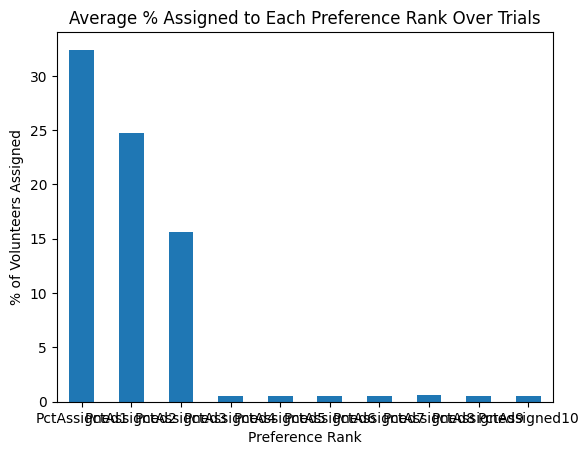

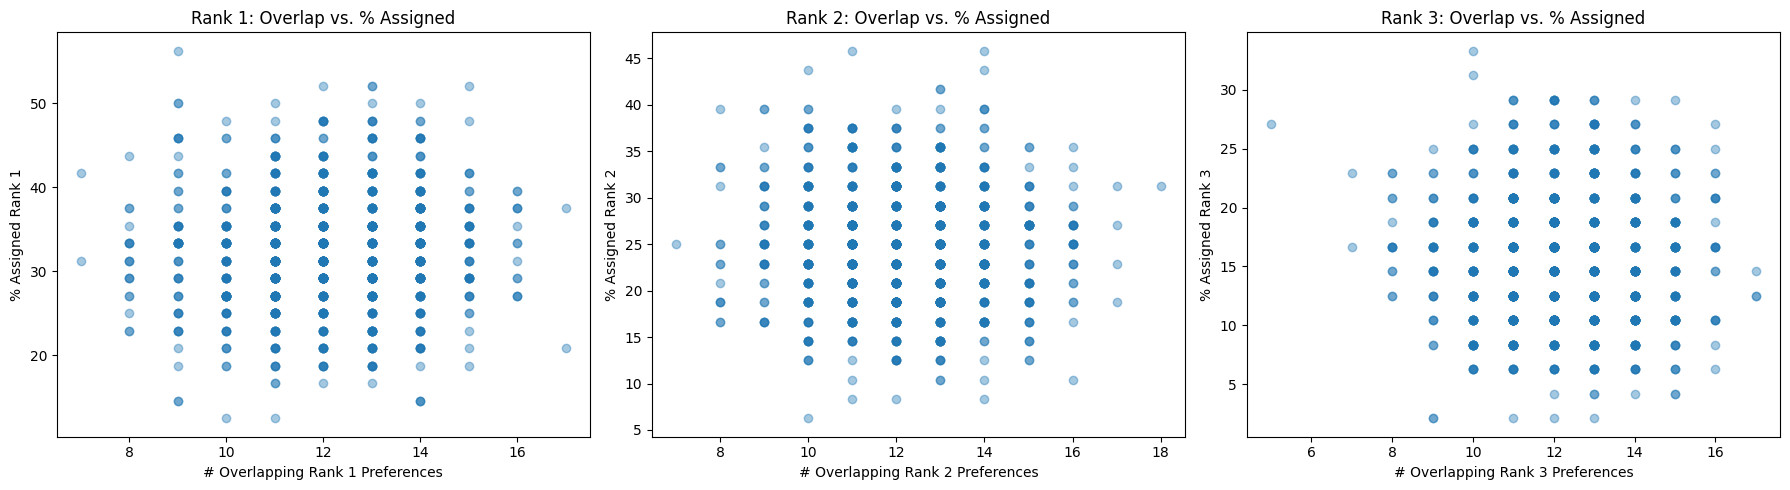

Correlation between overlap and assignment rates:
          PctAssigned1  PctAssigned2  PctAssigned3  PctAssigned4  \
Overlap1      0.051871      0.005513     -0.043608     -0.011352   
Overlap2      0.020071     -0.027014     -0.032904      0.026227   
Overlap3     -0.027599      0.062275     -0.032291     -0.000807   

          PctAssigned5  PctAssigned6  PctAssigned7  PctAssigned8  \
Overlap1      0.027068     -0.002349     -0.031980     -0.041423   
Overlap2     -0.009840     -0.012700      0.015801     -0.037426   
Overlap3      0.054019     -0.035352      0.056692     -0.046904   

          PctAssigned9  PctAssigned10  
Overlap1     -0.058237       0.011265  
Overlap2      0.016104      -0.054214  
Overlap3     -0.010642      -0.024334  


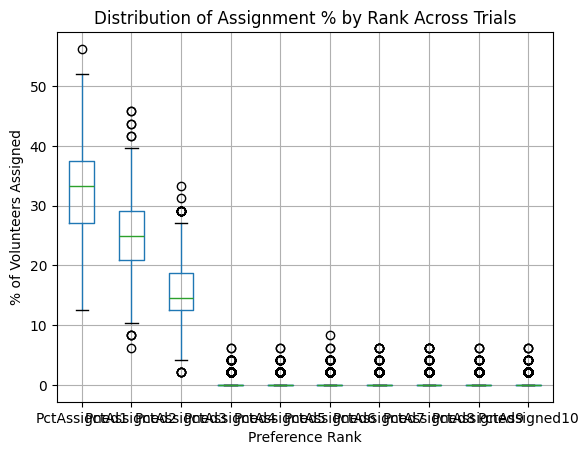

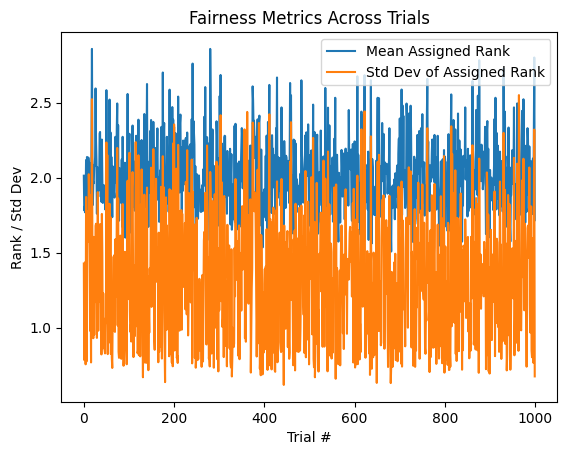

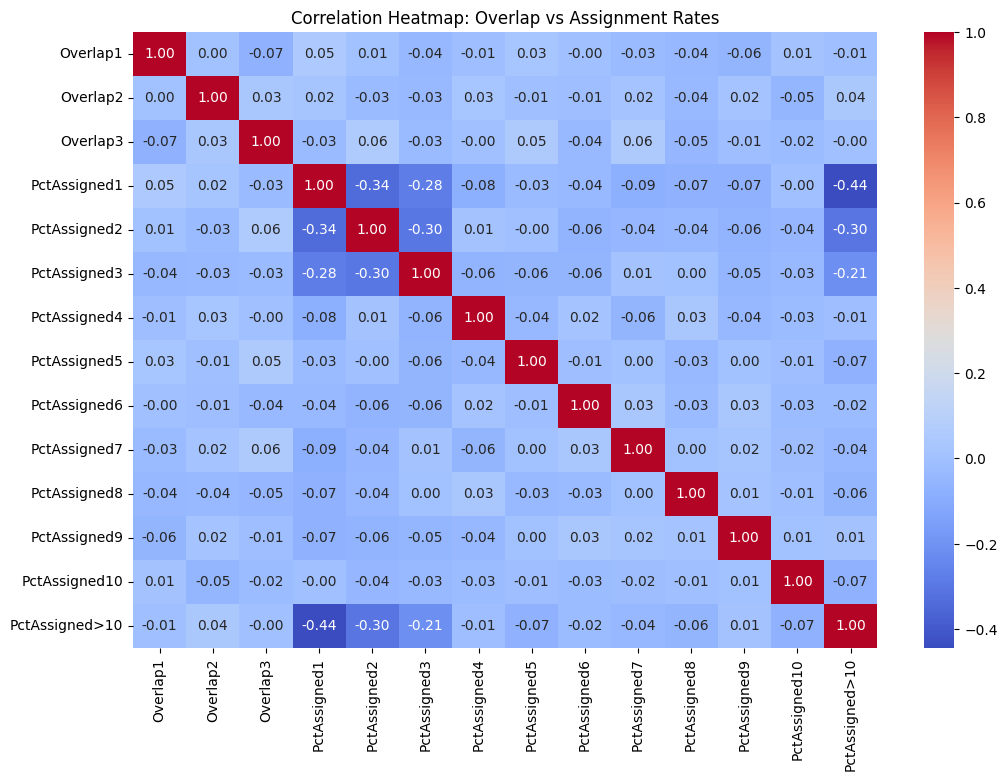

In [ ]:
import random
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

# Constants and inputs assumed already defined:
# volunteers, shifts (DataFrame), MIN_PTS, MAX_OVER, SEED

shift_ids = shifts["ShiftID"].tolist()
num_trials = 1000
max_rank_to_track = 10
trial_stats = []

for trial in range(num_trials):
    # Step 1: Random preferences (1 = best)
    random_prefs = {
        v: {s: rank for rank, s in enumerate(random.sample(shift_ids, len(shift_ids)), 1)}
        for v in volunteers
    }

    # Step 2: Overlap counts for 1st, 2nd, 3rd preferences
    overlap_counts = {}
    for pref_rank in [1, 2, 3]:
        selected_shifts = [
            shift for v_prefs in random_prefs.values()
            for shift, rank in v_prefs.items() if rank == pref_rank
        ]
        count_by_shift = Counter(selected_shifts)
        overlap_counts[pref_rank] = sum(1 for c in count_by_shift.values() if c > 1)

    # Step 3: Run solver
    _, assignments, *_ = run_shift_solver(
        volunteers=volunteers,
        shift_ids=shift_ids,
        shifts_df=shifts,
        prefs_input=random_prefs,
        min_points=MIN_PTS,
        max_over=MAX_OVER,
        seed=SEED
    )

    # Step 4: Count assignment rank stats
    assigned_counts = defaultdict(int)
    for v, assigned_shift in assignments.items():
        assigned_rank = random_prefs[v][assigned_shift]
        if assigned_rank <= max_rank_to_track:
            assigned_counts[assigned_rank] += 1
        else:
            assigned_counts[">10"] += 1

    # Step 5: Record stats
    row = {
        f"Overlap{r}": overlap_counts[r] for r in [1, 2, 3]
    }
    row.update({
        f"PctAssigned{r}": assigned_counts[r] / len(volunteers) * 100
        for r in range(1, max_rank_to_track + 1)
    })
    row["PctAssigned>10"] = assigned_counts[">10"] / len(volunteers) * 100
    trial_stats.append(row)

# === Analysis === #
df = pd.DataFrame(trial_stats)

# Average assignment rate bar chart
avg_assignment_rate = df[[f"PctAssigned{r}" for r in range(1, max_rank_to_track + 1)]].mean()
avg_assignment_rate.plot(kind='bar', title="Average % Assigned to Each Preference Rank Over Trials")
plt.xlabel("Preference Rank")
plt.ylabel("% of Volunteers Assigned")
plt.xticks(rotation=0)
plt.show()

# Scatter plots for overlap vs assignment %
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, rank in enumerate([1, 2, 3]):
    axes[i].scatter(df[f"Overlap{rank}"], df[f"PctAssigned{rank}"], alpha=0.4)
    axes[i].set_title(f"Rank {rank}: Overlap vs. % Assigned")
    axes[i].set_xlabel(f"# Overlapping Rank {rank} Preferences")
    axes[i].set_ylabel(f"% Assigned Rank {rank}")

plt.tight_layout()
plt.show()

# Correlation matrix
print("Correlation between overlap and assignment rates:")
print(df.corr(numeric_only=True).loc[[f"Overlap{r}" for r in [1, 2, 3]],
                                     [f"PctAssigned{r}" for r in range(1, max_rank_to_track + 1)]])

# Distribution boxplot of assignment % by rank
df[[f"PctAssigned{r}" for r in range(1, max_rank_to_track + 1)]].boxplot()
plt.title("Distribution of Assignment % by Rank Across Trials")
plt.xlabel("Preference Rank")
plt.ylabel("% of Volunteers Assigned")
plt.show()

rank_means, rank_stds = [], []

for row in trial_stats:
    ranks = []
    for r in range(1, max_rank_to_track + 1):
        count = row.get(f"PctAssigned{r}", 0)
        ranks.extend([r] * int(round(count)))  # approximate back from % to count
    mean_rank = pd.Series(ranks).mean() if ranks else float('nan')
    std_rank = pd.Series(ranks).std() if ranks else float('nan')
    rank_means.append(mean_rank)
    rank_stds.append(std_rank)

plt.plot(rank_means, label="Mean Assigned Rank")
plt.plot(rank_stds, label="Std Dev of Assigned Rank")
plt.title("Fairness Metrics Across Trials")
plt.xlabel("Trial #")
plt.ylabel("Rank / Std Dev")
plt.legend()
plt.show()

# correlation heatmap
import seaborn as sns

heatmap_data = df[[f"Overlap{r}" for r in [1, 2, 3]] +
                  [f"PctAssigned{r}" for r in range(1, max_rank_to_track + 1)] +
                  ["PctAssigned>10"]]

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap: Overlap vs Assignment Rates")
plt.show()


In [1]:
df

NameError: name 'df' is not defined